In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 

import torch 
import torch.nn.functional as F
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader, Dataset, random_split


from tqdm import tqdm 

import psweep as ps

In [2]:
import sys
sys.path.append('../code/utils')  # Add the utils directory to the Python path
import utils_data, utils_spikes, utils_events, utils_tensor, utils_pcn 

sys.path.append('../code/models')  # Add the models directory to the Python path
import pcn

# Damn it's working predictive coding is really genius work 
## Now let's try to learn pre and post structures, but also to merge dishes

## Merging dishes

In [3]:
# Experiment specific parameters 
chip_ids = [9501, 11614, 11615] # experiment ID
chip_sessions = [0,2] # 2 for post-training, 0 for pre-training

# Stable parameters
data_path = '../data/cortical_labs_data/' # path to data
fs = 20000 # sampling frequency
binsize = 100 # ms, bin size for spike counts
array_size = 1024 # number of electrode in the array

# Torch parameters 
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu") 
num_workers = 2
pin_memory = False

# Learn parameters
batch_size = 32
epochs = 100  # should be enough given the 07-07 notebook
n_inferences_steps = 500  # number of inference steps per input
n_generative_steps = 500 # number of generative steps per input

# Layer parameters
update_weights_flag = True  # whether to learn the FF weights
f = utils_pcn.tanh
df = utils_pcn.tanh_deriv

# Network parameters
fixed_predictions = True  # change the predictions or not
theta_lr = 5e-4
mu_lr = 5e-2
weight_clamp = 50  # weight clamp
mu_clamp = 1000  # value neuron clamp

L1_size = 256
L2_size = 128
L3_size = 256

In [4]:
# define the start and end of the desired time window in seconds
start_time_window = 60*0 # 5 minutes
end_time_window = 60*5 # 10 minutes

all_sensory_spikes = []
all_motor_spikes = []

for i_chipid, chip_id in enumerate(chip_ids):
    for i_chip_session, chip_session in enumerate(chip_sessions):
        print('Loading for chip {}, session {}'.format(chip_id, chip_session))
        try:
            data_subset, events = utils_data.load_file(chip_id, chip_session, data_path)
        except:
            print(f'>>Could not load chip {chip_id}, session {chip_session}<<')
            print('------------------------\n')
            continue
        spiketimes = utils_data.get_spiketimes(data_subset, array_size,fs)
        sensory_spikes, up1_spikes, up2_spikes, down1_spikes, down2_spikes = utils_data.get_electrode_regions(data_subset, spiketimes, do_plot = False)

        all_spikes = [sensory_spikes, up1_spikes, up2_spikes, down1_spikes, down2_spikes]
        max_time_ms = max(max(max(spikes) for spikes in spike_list)*1000 for spike_list in all_spikes)

        sensory_spikes_binned = utils_tensor.spike_times_to_bins(sensory_spikes, binsize, max_time_ms, spike_tag = 'sensory')
        up1_spikes_binned = utils_tensor.spike_times_to_bins(up1_spikes, binsize, max_time_ms, spike_tag = 'up1')
        down1_spikes_binned = utils_tensor.spike_times_to_bins(down1_spikes, binsize, max_time_ms, spike_tag='down1')
        up2_spikes_binned = utils_tensor.spike_times_to_bins(up2_spikes, binsize, max_time_ms, spike_tag = 'up2')
        down2_spikes_binned = utils_tensor.spike_times_to_bins(down2_spikes, binsize, max_time_ms, spike_tag = 'down2')

        # Determine how many bins correspond to the desired time window
        start_window_bins = int(start_time_window / (binsize/1000))
        end_window_bins = int(end_time_window / (binsize/1000))
        
        # Slice the tensors
        sensory_spikes_binned = sensory_spikes_binned[:,start_window_bins:end_window_bins]
        motor_spikes_binned = torch.cat([up1_spikes_binned[:,start_window_bins:end_window_bins], 
                                        down1_spikes_binned[:,start_window_bins:end_window_bins], 
                                        up2_spikes_binned[:,start_window_bins:end_window_bins], 
                                        down2_spikes_binned[:,start_window_bins:end_window_bins]], dim = 0)

        # Add the binned spikes to their respective lists
        all_sensory_spikes.append(sensory_spikes_binned)
        all_motor_spikes.append(motor_spikes_binned)
        
        print('------------------------\n')

# Concatenate all sensory and motor binned spikes into two separate tensors
sensory_spikes_binned = torch.cat(all_sensory_spikes, dim=1)
motor_spikes_binned = torch.cat(all_motor_spikes, dim=1)

Loading for chip 9501, session 0


Loading data...: 100%|██████████| 29/29 [00:00<00:00, 39.82it/s]


Stimulation mode: full game


Binning sensory channels: 100%|██████████| 500/500 [00:00<00:00, 11380.00it/s]
/media/hugo/HDD Alpha/github-hdd/BrainDishSiMulator/notebooks/../code/utils/utils_tensor.py:19: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  return torch.tensor(binned_spikes)
Binning down2 channels: 100%|██████████| 100/100 [00:00<00:00, 10335.38it/s]


------------------------

Loading for chip 9501, session 2


Loading data...: 100%|██████████| 29/29 [00:00<00:00, 41.76it/s]


Stimulation mode: full game


Binning down2 channels: 100%|██████████| 100/100 [00:00<00:00, 10462.74it/s]


------------------------

Loading for chip 11614, session 0


Loading data...: 100%|██████████| 29/29 [00:00<00:00, 43.79it/s]


Stimulation mode: full game


Binning down2 channels: 100%|██████████| 100/100 [00:00<00:00, 10842.48it/s]


------------------------

Loading for chip 11614, session 2


Loading data...: 100%|██████████| 29/29 [00:00<00:00, 43.14it/s]


Stimulation mode: full game


Binning down2 channels: 100%|██████████| 100/100 [00:00<00:00, 10379.63it/s]


------------------------

Loading for chip 11615, session 0


Loading data...: 100%|██████████| 29/29 [00:00<00:00, 43.76it/s]


>>Could not load chip 11615, session 0<<
------------------------

Loading for chip 11615, session 2


Loading data...: 100%|██████████| 29/29 [00:00<00:00, 42.33it/s]


Stimulation mode: full game


Binning down2 channels: 100%|██████████| 100/100 [00:00<00:00, 12525.55it/s]

------------------------



In [5]:
print(sensory_spikes_binned.shape)
print(motor_spikes_binned.shape)
print(end_window_bins-start_window_bins)

torch.Size([500, 15000])
torch.Size([400, 15000])
3000


In [6]:
class NormalizeDataset(Dataset):
    def __init__(self, tensor):
        self.tensor = tensor
        '''min_val = torch.min(tensor)
        max_val = torch.max(tensor)
        tensor = 2 * (tensor - min_val) / (max_val - min_val) - 1'''
        
    def __len__(self):
        return self.tensor.shape[1]

    def __getitem__(self, index):
        sample = self.tensor[:, index]

        return sample

# Initialize the dataset for sensory spikes
dataset_sensory = NormalizeDataset(sensory_spikes_binned)

train_size_sensory = int(0.8 * len(dataset_sensory))
test_size_sensory = len(dataset_sensory) - train_size_sensory
train_dataset_sensory, test_dataset_sensory = random_split(dataset_sensory, [train_size_sensory, test_size_sensory])

train_dataloader_sensory = DataLoader(train_dataset_sensory, batch_size=batch_size, shuffle=True,
                                    num_workers = num_workers, pin_memory = pin_memory, drop_last = True)
test_dataloader_sensory = DataLoader(test_dataset_sensory, batch_size=batch_size, shuffle=False,
                                    num_workers = num_workers, pin_memory = pin_memory, drop_last = True)

# Initialize the dataset for motor spikes
dataset_motor = NormalizeDataset(motor_spikes_binned)

train_size_motor = int(0.8 * len(dataset_motor))
test_size_motor = len(dataset_motor) - train_size_motor
train_dataset_motor, test_dataset_motor = random_split(dataset_motor, [train_size_motor, test_size_motor])

train_dataloader_motor = DataLoader(train_dataset_motor, batch_size=batch_size, shuffle=True,
                                    num_workers = num_workers, pin_memory = pin_memory)
test_dataloader_motor = DataLoader(test_dataset_motor, batch_size=batch_size, shuffle=False,
                                    num_workers = num_workers, pin_memory = pin_memory)

# Building the network

In [7]:
# Building the network
shapes = [sensory_spikes_binned.shape[0], L1_size, L2_size, L3_size, motor_spikes_binned.shape[0]]
layers = []
for i in range(len(shapes)-1) :
    print('Layer', i, ' : ', shapes[i], ' -> ', shapes[i+1])
    layers.append(pcn.FCLayer(input_size = shapes[i],
                            output_size = shapes[i+1], f = f, df = df,
                            device = device))

Layer 0  :  500  ->  256
Layer 1  :  256  ->  128
Layer 2  :  128  ->  256
Layer 3  :  256  ->  400


In [8]:
model = pcn.PCNet_Bogacz(layers = layers, batch_size = batch_size,
                        n_inferences_steps = n_inferences_steps,
                        mu_lr = mu_lr, theta_lr = theta_lr, pi_lr = 42,
                        fixed_predictions = fixed_predictions, update_weights_flag=update_weights_flag,
                        weight_clamp = weight_clamp, mu_clamp = mu_clamp,  pi_clamp = 42,
                        device = device, do_pi = False,
                        mode = 'mse')

Training...: 100%|██████████| 40/40 [50:55<00:00, 76.39s/it]


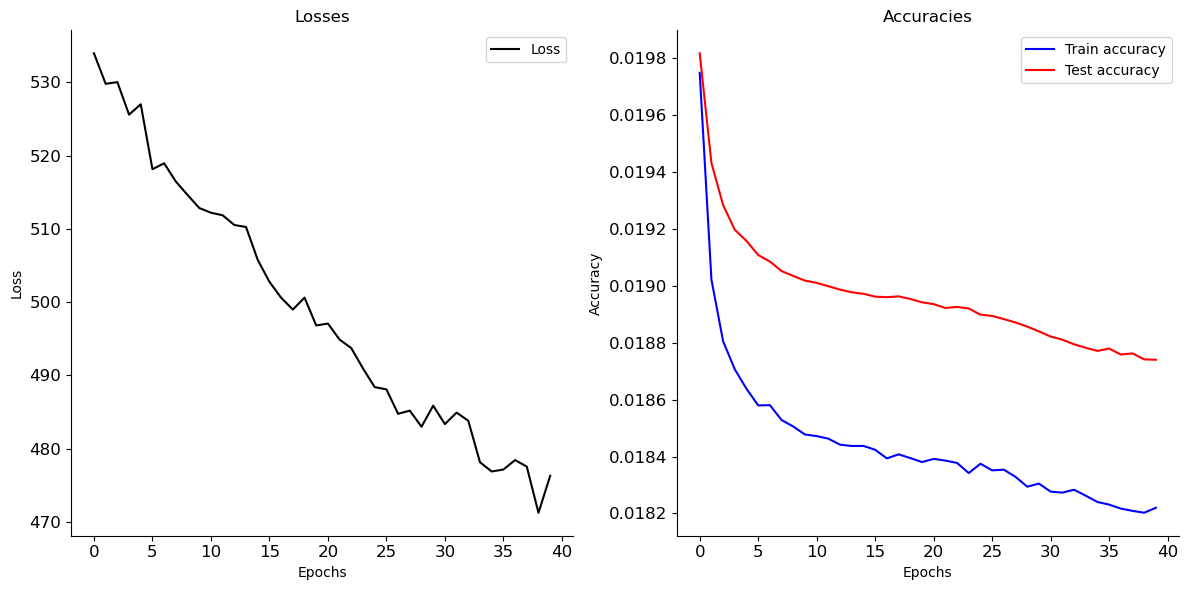

In [9]:
# GPU burning
losses, accs, test_accs = pcn.train_mse(model = model,
                                        inputs_dataloader = train_dataloader_sensory, 
                                        outputs_dataloader = train_dataloader_motor,
                                        test_inputs_dataloader = test_dataloader_sensory,
                                        test_outputs_dataloader = test_dataloader_motor, 
                                        n_epochs = epochs)

utils_pcn.plot_loss_accs(losses, accs, test_accs)

IndexError: index 24 is out of bounds for dimension 0 with size 24

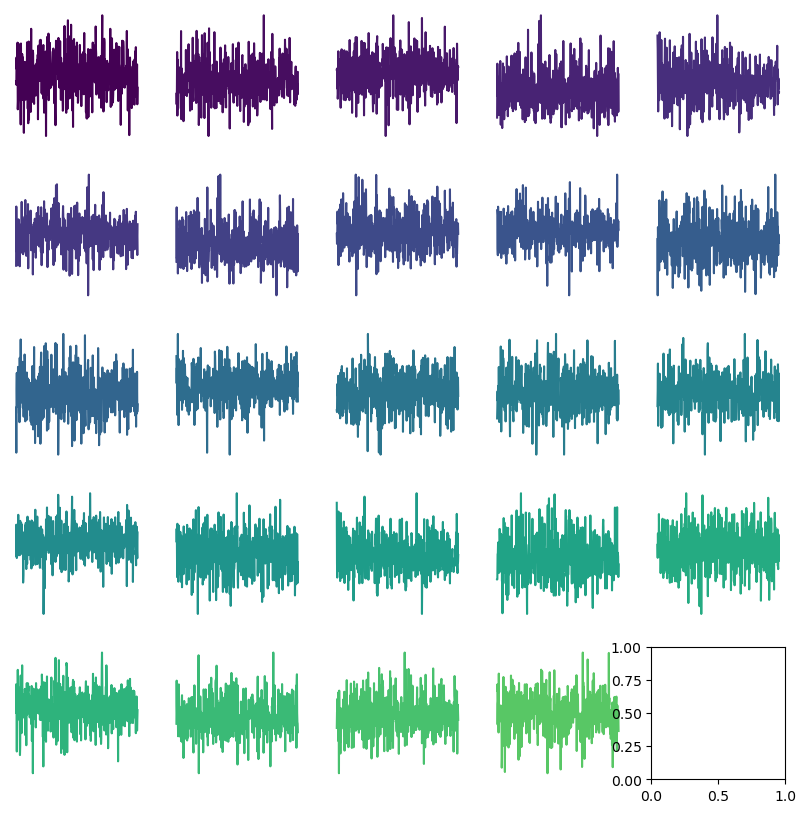

In [11]:
# Generative mode
gen_firing_rates = model.hard_generate(y=torch.randn_like(torch.empty(batch_size, 400), device=device), 
                                    n_generative_steps=n_generative_steps)

# Visualization
# Here I am assuming your gen_firing_rates are reshaped correctly for visualization.
fig, axs = plt.subplots(figsize=(10,10), ncols=int(np.sqrt(batch_size)), nrows=int(np.sqrt(batch_size)))
cols = plt.cm.viridis(np.linspace(0, 1, batch_size))
for iax, ax in enumerate(axs.flatten()):
    ax.plot(gen_firing_rates[iax].cpu().detach().numpy(), c=cols[iax])
    ax.axis('off')
plt.show()